# wywołujmey sześć poniższych komórek i zjedżamy na sam dół

In [44]:
import os
import pandas as pd
import time
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy,
)
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas.llms import LangchainLLMWrapper   
from ragas.embeddings import LangchainEmbeddingsWrapper



C:\Users\Administrator\AppData\Local\Temp\ipykernel_29112\4250103486.py:9: DeprecationWarning: Importing context_precision from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import context_precision
  from ragas.metrics import (
C:\Users\Administrator\AppData\Local\Temp\ipykernel_29112\4250103486.py:9: DeprecationWarning: Importing context_recall from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import context_recall
  from ragas.metrics import (
C:\Users\Administrator\AppData\Local\Temp\ipykernel_29112\4250103486.py:9: DeprecationWarning: Importing faithfulness from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import faithfulness
  from ragas.metrics import (
C:\Users\Administrator\App

In [ ]:
# os.environ["OPENAI_API_KEY"] =""
# judge_llm_raw = ChatOpenAI(
#     model="mistralai/mistral-large-2411",
#     openai_api_key=os.environ["OPENAI_API_KEY"], # Przekazujemy klucz jawnie
#     base_url="https://openrouter.ai/api/v1",
#     temperature=0,      # Sędzia musi być precyzyjny
#     timeout=200.0,      
#     max_retries=5
# )

# # Pakujemy w wrapper Ragas
# judge_llm = LangchainLLMWrapper(judge_llm_raw)


# # 2. Konfiguracja Embeddingów
# judge_embeddings_raw = OpenAIEmbeddings(
#     model="openai/text-embedding-3-small",
#     openai_api_key=os.environ["OPENAI_API_KEY"], # Przekazujemy klucz jawnie
#     openai_api_base="https://openrouter.ai/api/v1", 
#     check_embedding_ctx_length=False,
#     timeout=70.0,
#     max_retries=5
# )

# # Pakujemy w wrapper Ragas
# judge_embeddings = LangchainEmbeddingsWrapper(judge_embeddings_raw)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_29112\410884087.py:12: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  judge_llm = LangchainLLMWrapper(judge_llm_raw)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_29112\410884087.py:26: DeprecationWarning: LangchainEmbeddingsWrapper is deprecated and will be removed in a future version. Use the modern embedding providers instead: embedding_factory('openai', model='text-embedding-3-small', client=openai_client) or from ragas.embeddings import OpenAIEmbeddings, GoogleEmbeddings, HuggingFaceEmbeddings
  judge_embeddings = LangchainEmbeddingsWrapper(judge_embeddings_raw)


In [ ]:
os.environ["OPENAI_API_KEY"] = "" 
judge_llm = ChatOpenAI(
    model="gpt-4o-mini",
    timeout=200.0,  
    temperature=0,    
    max_retries=5       
)


judge_embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    timeout=60.0,
    max_retries=5
)



In [46]:
def evaluate_rag_file(label, filename):
    print(f"starting evaluation: {label} ({filename})...")
    
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"file not found: {filename}")
        return None

    ragas_dict = {
        "question": [],
        "answer": [],
        "contexts": [],
        "ground_truth": []
    }

    for item in data:
        if "ERROR" in item.get("answer", ""): continue
        ragas_dict["question"].append(item["question"])
        ragas_dict["answer"].append(item["answer"])
        ragas_dict["contexts"].append(item["contexts"]) 
        ragas_dict["ground_truth"].append(item["ground_truth"])

    full_dataset = Dataset.from_dict(ragas_dict)
    BATCH_SIZE = 1
    results_list = []
    
    total_items = len(full_dataset)
    
    print(f"processing {total_items} questions in batch size: {BATCH_SIZE}...")

    for i in range(0, total_items, BATCH_SIZE):
        end_idx = min(i + BATCH_SIZE, total_items)
        batch = full_dataset.select(range(i, end_idx))
        
        try:
            print(f"evaluating question {i}")
            time.sleep(2)
            batch_result = evaluate(
                dataset=batch,
                metrics=[
                    context_precision,
                    context_recall,
                    faithfulness,
                    answer_relevancy,
                ],
                llm=judge_llm,
                embeddings=judge_embeddings
            )
            results_list.append(batch_result.to_pandas())
            
        except Exception as e:
            print(f"error with question {i}-{end_idx}: {e}")
            continue

    if results_list:
        df_res = pd.concat(results_list, ignore_index=True)
        df_res["Config"] = label
        print(f"evaluation complete {label}!")
        return df_res
    else:
        print(f"evaluation failed {label}")
        return None

In [47]:
def calculate_all_results(FILES):
    all_results = []
    for label, filename in FILES.items():
        df_result = evaluate_rag_file(label, filename)
        
        if df_result is not None:
            all_results.append(df_result)
    return all_results

In [48]:
def save_and_summarize_results(all_results, filename="RAG_Analysis_Results.xlsx"):
    if all_results:
        final_df = pd.concat(all_results, ignore_index=True)
        final_df.to_excel(filename, index=False)
        print(f"\n Results saved to {filename}")
        print("\n--- Average Scores ---")
        summary = final_df.groupby("Config")[["context_recall", "context_precision", "faithfulness", "answer_relevancy"]].mean()
        display(summary)
    else:
        print(" No results generated.")
    return final_df if all_results else None

In [49]:
def plot_results(final_df, title):
    sns.set_theme(style="whitegrid")

    df_melted = final_df.melt(
        id_vars=["Config"], 
        value_vars=["context_recall", "context_precision", "faithfulness", "answer_relevancy"],
        var_name="Metric", 
        value_name="Score"
    )

    metric_names = {
        "context_recall": "Context Recall",
        "context_precision": "Context Precision",
        "faithfulness": "Faithfulness",
        "answer_relevancy": "Answer Relevancy"
    }
    df_melted["Metric"] = df_melted["Metric"].map(metric_names)

    plt.figure(figsize=(14, 7))

    chart = sns.barplot(
        data=df_melted, 
        x="Metric", 
        y="Score", 
        hue="Config", 
        palette="viridis",
        errorbar=None      
    )

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Evaluation Metric", fontsize=12)
    plt.ylabel("Score (0.0 - 1.0)", fontsize=12)
    plt.legend(title="Configuration", title_fontsize='11', loc='lower right')
    plt.ylim(0, 1.1) 
    for container in chart.containers:
        chart.bar_label(container, fmt='%.2f', padding=3)

    plt.tight_layout()
    plt.show()

# UWAGA!!!!!!!!!!!!!!!!!!

## dalej juz nie wywolujemy i jedziemy na koniec

In [ ]:
FILES = {
    "Chunk 512": "results_chunk_512_overlap_100_voyage3lite_gptmini.json",
    "Chunk 1000": "results_chunk_1000_overlap_200_voyage3lite_gptmini.json",
    "Chunk 2000": "results_chunk_2000_overlap_400_voyage3lite_gptmini.json"
}

In [7]:
all_results =  calculate_all_results(FILES):

starting evaluation: Chunk 512 (results_chunk_512_overlap_100_voyage3lite_gptmini.json)...
processing 30 questions in batch size: 1...


Evaluating:  50%|█████     | 2/4 [00:12<00:12,  6.37s/it]Exception raised in Job[2]: OutputParserException(Invalid json output: {
    "statements": [
        "The Apriori algorithm is a fundamental method in data mining.",
        "The Apriori algorithm is used to discover association rules from market basket data.",
        "The workflow of the Apriori algorithm includes several steps from the initial data to actionable association rules.",
        "The first step is data preparation.",
        "The input data is a dataset, typically in the form of a binary incidence matrix.",
        "Each row in the binary incidence matrix represents a transaction.",
        "Each column in the binary incidence matrix represents an item.",
        "In a mushroom dataset, each transaction might indicate whether certain types of mushrooms were purchased.",
        "The dataset must be binary, meaning that each entry is either 0 or 1.",
        "An entry of 0 indicates that an item was not purchased.",

evaluation complete Chunk 512!
starting evaluation: Chunk 1000 (results_chunk_1000_overlap_200_voyage3lite_gptmini.json)...
processing 29 questions in batch size: 1...


Evaluating: 100%|██████████| 4/4 [00:59<00:00, 14.85s/it]


evaluation complete Chunk 1000!
starting evaluation: Chunk 2000 (results_chunk_2000_overlap_400_voyage3lite_gptmini.json)...
processing 30 questions in batch size: 1...


Evaluating: 100%|██████████| 4/4 [00:50<00:00, 12.66s/it]


evaluation complete Chunk 2000!


In [10]:
df_final = save_and_summarize_results(all_results, filename="RAG_Analysis_Results.xlsx")


 Results saved to 'RAG_Analysis_Results.xlsx'

--- Average Scores ---


,context_recall,context_precision,faithfulness,answer_relevancy
Config,,,,
Chunk 1000,0.756568,0.318591,0.867988,0.830368
Chunk 2000,0.727778,0.263328,0.873945,0.819523
Chunk 512,0.819048,0.369832,0.934002,0.843719


In [35]:
def plot_results(final_df, title):
    sns.set_theme(style="whitegrid")

    df_melted = final_df.melt(
        id_vars=["Config"], 
        value_vars=["context_recall", "context_precision", "faithfulness", "answer_relevancy"],
        var_name="Metric", 
        value_name="Score"
    )

    metric_names = {
        "context_recall": "Context Recall",
        "context_precision": "Context Precision",
        "faithfulness": "Faithfulness",
        "answer_relevancy": "Answer Relevancy"
    }
    df_melted["Metric"] = df_melted["Metric"].map(metric_names)

    plt.figure(figsize=(14, 7))

    chart = sns.barplot(
        data=df_melted, 
        x="Metric", 
        y="Score", 
        hue="Config", 
        palette="viridis",
        errorbar=None      
    )

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Evaluation Metric", fontsize=12)
    plt.ylabel("Score (0.0 - 1.0)", fontsize=12)
    plt.legend(title="Configuration", title_fontsize='11', loc='lower right')
    plt.ylim(0, 1.1) 
    for container in chart.containers:
        chart.bar_label(container, fmt='%.2f', padding=3)

    plt.tight_layout()
    plt.show()

### CLEANED CONTEXTS, BC PREVOIUS WAS A MESS

In [16]:
FILES_2 = {
    "Chunk 512": "results_chunk_512_overlap_100_voyage3lite_gptmini_CLEANED.json",
    "Chunk 1000": "results_chunk_1000_overlap_200_voyage3lite_gptmini_CLEANED.json",
    "Chunk 2000": "results_chunk_2000_overlap_400_voyage3lite_gptmini_CLEANED.json"
}

In [17]:
all_results2 = calculate_all_results(FILES_2)

starting evaluation: Chunk 512 (results_chunk_512_overlap_100_voyage3lite_gptmini_CLEANED.json)...
processing 30 questions in batch size: 1...


Evaluating: 100%|██████████| 4/4 [00:55<00:00, 13.85s/it]


evaluation complete Chunk 512!
starting evaluation: Chunk 1000 (results_chunk_1000_overlap_200_voyage3lite_gptmini_CLEANED.json)...
processing 29 questions in batch size: 1...


Evaluating: 100%|██████████| 4/4 [00:53<00:00, 13.45s/it]


evaluation complete Chunk 1000!
starting evaluation: Chunk 2000 (results_chunk_2000_overlap_400_voyage3lite_gptmini_CLEANED.json)...
processing 30 questions in batch size: 1...


Evaluating: 100%|██████████| 4/4 [00:55<00:00, 13.93s/it]


evaluation complete Chunk 2000!


In [18]:
final_df_2 = save_and_summarize_results(all_results_2, filename="RAG_Analysis_Results_2.xlsx")


 Results saved to 'RAG_Analysis_Results_2.xlsx'

--- Average Scores ---


,context_recall,context_precision,faithfulness,answer_relevancy
Config,,,,
Chunk 1000,0.789163,0.337534,0.902248,0.828606
Chunk 2000,0.776534,0.264464,0.957662,0.817875
Chunk 512,0.878836,0.379903,0.955088,0.843359


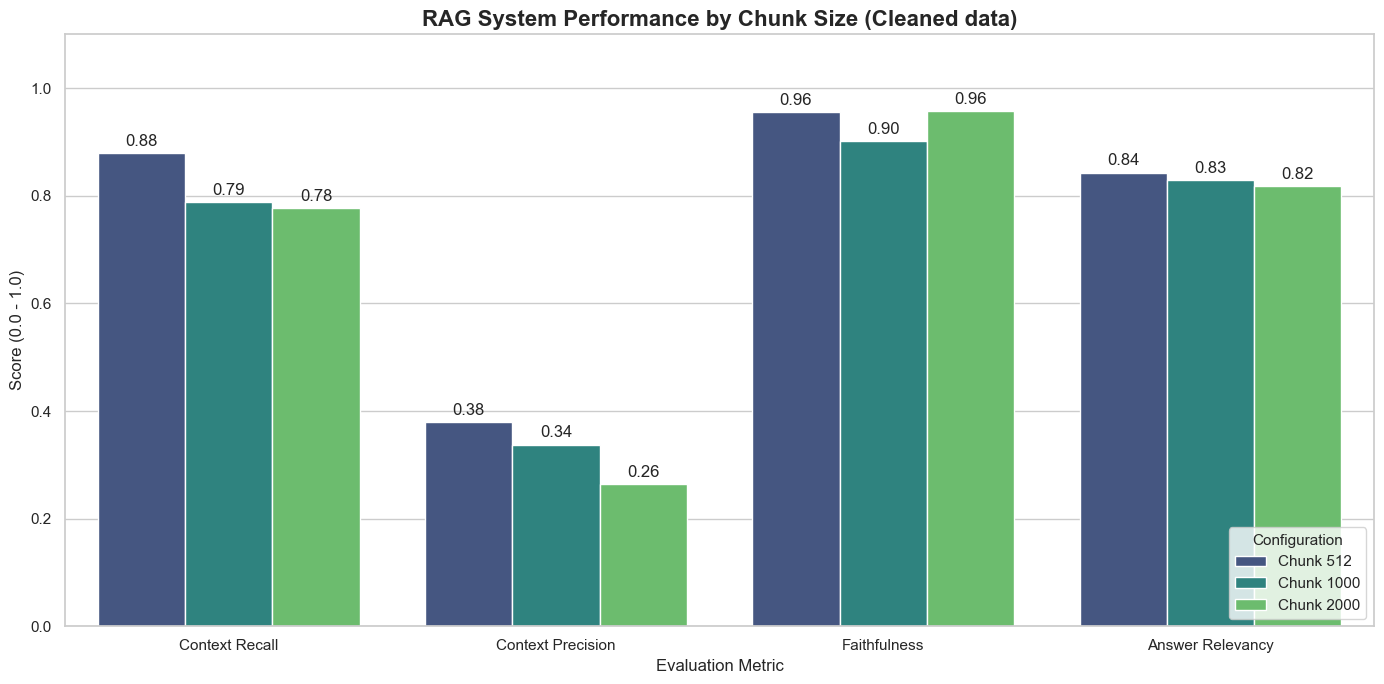

In [19]:
plot_results(final_df_2, "RAG System Performance by Chunk Size (Cleaned data)")

## embeddings models test

In [79]:
EMBEDDINGS_FILES = {    
    "voyage-lite-3": "results_chunk_512_overlap_100_voyage3lite_gptmini_topk10_dist055.json",
    "voyage-2-large": "results_chunk_512_overlap_100_voyagelarge2_gptmini_topk10_dist055.json",
    "text-to-embeddings-3-small": "results_chunk_512_overlap_100_textembedding3small_gptmini_topk10_dist055.json",
    "text-to-embeddings-3-large": "results_chunk_512_overlap_100_textembedding3large_gptmini_topk10_dist055.json"}

In [26]:
all_results = calculate_all_results(EMBEDDINGS_FILES)

starting evaluation: voyage-lite-3 (results_chunk_512_overlap_100_voyage3lite_gptmini_topk10_dist055.json)...
processing 30 questions in batch size: 1...


Evaluating:  50%|█████     | 2/4 [00:38<00:33, 16.68s/it]Exception raised in Job[0]: TimeoutError()
Exception raised in Job[2]: TimeoutError()
Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.66s/it]


evaluation complete voyage-lite-3!
starting evaluation: voyage-2-large (results_chunk_512_overlap_100_voyagelarge2_gptmini_topk10_dist055.json)...
processing 30 questions in batch size: 1...


Evaluating:  25%|██▌       | 1/4 [00:03<00:11,  3.68s/it]Exception ignored in: <function ZipFile.__del__ at 0x000001A1B5453E50>
Traceback (most recent call last):
  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\zipfile.py", line 1816, in __del__
    self.close()
  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\zipfile.py", line 1833, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file
Evaluating:  75%|███████▌  | 3/4 [00:28<00:10, 10.61s/it]Exception raised in Job[2]: OutputParserException(Invalid json output: {
    "statements": [
        "The Apriori algorithm is a fundamental method in data mining.",
        "The Apriori algorithm is used to discover association rules from market basket data.",
        "The complete workflow of the Apriori algorithm consists of several steps.",
        "The first step is data preparation.",
        "Data preparation begins with market basket data.",
        "Market basket data 

evaluation complete voyage-2-large!
starting evaluation: text-to-embeddings-3-small (results_chunk_512_overlap_100_textembedding3small_gptmini_topk10_dist055.json)...
processing 30 questions in batch size: 1...


Evaluating: 100%|██████████| 4/4 [00:46<00:00, 11.55s/it]


evaluation complete text-to-embeddings-3-small!
starting evaluation: text-to-embeddings-3-large (results_chunk_512_overlap_100_textembedding3large_gptmini_topk10_dist055.json)...
processing 30 questions in batch size: 1...


Evaluating:  75%|███████▌  | 3/4 [00:16<00:05,  5.92s/it]Exception raised in Job[2]: OutputParserException(Invalid json output: {"statements": ["Information theory defines \"information\" in terms of the uncertainty associated with the occurrence of an event.", "The amount of information ( I ) gained from observing an event with probability ( p ) is given by the formula: ( I(p) = -\log_2(p) ).", "The information content increases as the probability of the event decreases.", "If a fair coin is flipped, the probability of getting heads (or tails) is ( \frac{1}{2} ).", "Plugging ( \frac{1}{2} ) into the formula gives: ( I\left(\frac{1}{2}\right) = -\log_2\left(\frac{1}{2}\right) = 1 \text{ bit} ).", "A fair coin flip provides 1 bit of information because it is equally likely to land on either side.", "If an event has a probability of 1, meaning it is certain to happen, the information gained from that event is 0.", "There is no uncertainty when an event is certain.", "The definition of in

evaluation complete text-to-embeddings-3-large!


In [27]:
final_df = save_and_summarize_results(all_results, filename="RAG_Analysis_embeddings_results.xlsx")


 Results saved to RAG_Analysis_embeddings_results.xlsx

--- Average Scores ---


,context_recall,context_precision,faithfulness,answer_relevancy
Config,,,,
text-to-embeddings-3-large,0.834418,0.802197,0.910100,0.850281
text-to-embeddings-3-small,0.716296,0.798870,0.922114,0.838929
voyage-2-large,0.877474,0.499609,0.883926,0.802694
voyage-lite-3,0.858929,0.465597,0.936957,0.840807


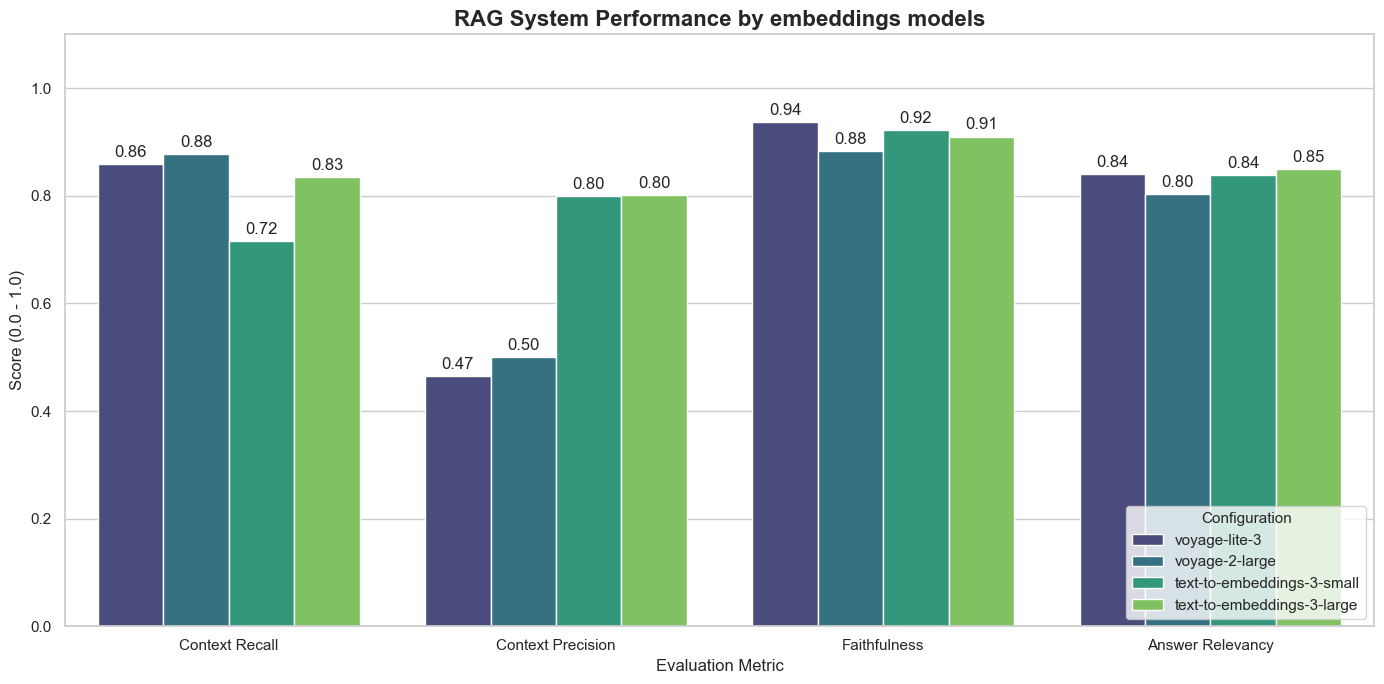

In [28]:
plot_results(final_df, "RAG System Performance by embeddings models")

In [ ]:
all_results = calculate_all_results(EMBEDDINGS_FILES)

# LLMS TESTS

In [40]:
LLMS_FILES = {    
    "gpt4o-mini": "results_chunk_512_overlap_100_voyage3lite_gptmini_topk10_dist045.json",
    "llama-3.3-70B": "results_chunk_512_overlap_100_voyage3lite_llama3370B_topk10_dist045.json",
    "gemini-2.0-flash": "results_chunk_512_overlap_100_voyage3lite_gemini20_flash_topk10_dist045.json",
    "deepseek-v3.2": "results_chunk_512_overlap_100_voyage3lite_deepseek_v3_2_topk10_dist045.json"}

In [42]:
all_results_LLMS = calculate_all_results(LLMS_FILES)

starting evaluation: gpt4o-mini (results_chunk_512_overlap_100_voyage3lite_gptmini_topk10_dist045.json)...
processing 30 questions in batch size: 1...


Evaluating:  75%|███████▌  | 3/4 [00:22<00:07,  7.26s/it]Exception raised in Job[2]: OutputParserException(Failed to parse StringIO from completion {"statements": ["CART stands for Classification and Regression Trees.", "CART uses a systematic approach to perform regression tree splitting.", "CART evaluates different attributes in the dataset to determine which attribute to split on.", "CART looks for the attribute that minimizes the prediction error.", "CART only allows binary splits.", "Each binary split divides the data into two groups based on a threshold value for the chosen attribute.", "The binary approach simplifies the splitting criteria.", "The binary approach makes the tree easier to interpret.", "CART assesses potential split points for each attribute.", "CART selects the split point that results in the lowest empirical error.", "The empirical error is calculated using the least squares loss function.", "The least squares loss function is defined as the sum of the squared d

evaluation complete gpt4o-mini!
starting evaluation: llama-3.3-70B (results_chunk_512_overlap_100_voyage3lite_llama3370B_topk10_dist045.json)...
processing 30 questions in batch size: 1...


Evaluating: 100%|██████████| 4/4 [00:30<00:00,  7.67s/it]


evaluation complete llama-3.3-70B!
starting evaluation: gemini-2.0-flash (results_chunk_512_overlap_100_voyage3lite_gemini20_flash_topk10_dist045.json)...
processing 30 questions in batch size: 1...


Evaluating: 100%|██████████| 4/4 [00:27<00:00,  6.86s/it]


evaluation complete gemini-2.0-flash!
starting evaluation: deepseek-v3.2 (results_chunk_512_overlap_100_voyage3lite_deepseek_v3_2_topk10_dist045.json)...
processing 29 questions in batch size: 1...


Evaluating: 100%|██████████| 4/4 [00:31<00:00,  7.83s/it]


evaluation complete deepseek-v3.2!


In [45]:
final_df_LLMS = save_and_summarize_results(all_results_LLMS, filename="RAG_Analysis_LLMs_results.xlsx")


 Results saved to RAG_Analysis_LLMs_results.xlsx

--- Average Scores ---


,context_recall,context_precision,faithfulness,answer_relevancy
Config,,,,
deepseek-v3.2,0.678612,0.733037,0.836078,0.768150
gemini-2.0-flash,0.644008,0.697614,0.880612,0.786832
gpt4o-mini,0.639405,0.708461,0.934894,0.811859
llama-3.3-70B,0.592368,0.712093,0.807539,0.728311


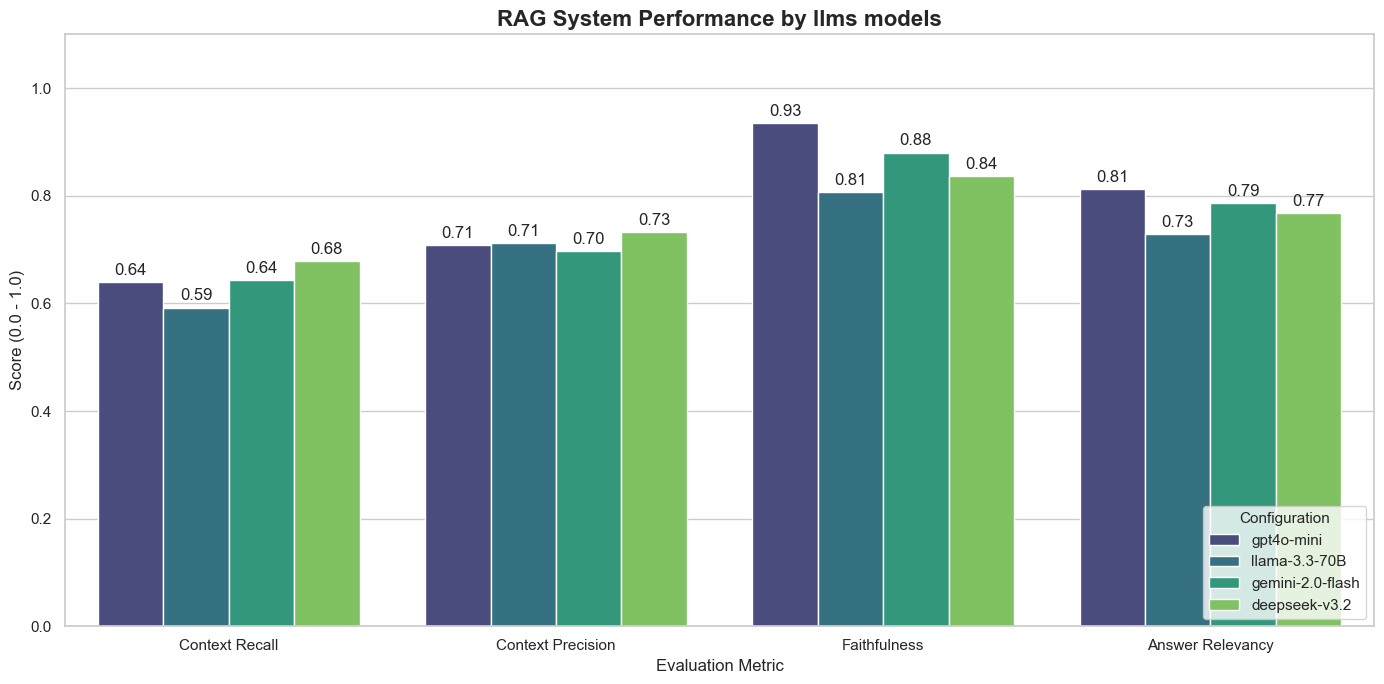

In [46]:
plot_results(final_df_LLMS, "RAG System Performance by llms models")

## Diffrent judge(MISTRAL LARGE 2411) withoyt ollama

In [8]:
LLMS_FILES_2 = {    
    "gpt4o-mini": "results_chunk_512_overlap_100_voyage3lite_gptmini_topk10_dist045.json",
    "gemini-2.0-flash": "results_chunk_512_overlap_100_voyage3lite_gemini20_flash_topk10_dist045.json",
    "deepseek-v3.2": "results_chunk_512_overlap_100_voyage3lite_deepseek_v3_2_topk10_dist045.json"}

In [23]:
all_results_LLMS_2 = calculate_all_results(LLMS_FILES_2)

starting evaluation: gpt4o-mini (results_chunk_512_overlap_100_voyage3lite_gptmini_topk10_dist045.json)...
processing 30 questions in batch size: 1...
evaluating questions 0 to 1...


Evaluating: 100%|██████████| 4/4 [00:53<00:00, 13.32s/it]


evaluating questions 1 to 2...


Evaluating: 100%|██████████| 4/4 [00:42<00:00, 10.55s/it]


evaluating questions 2 to 3...


Evaluating: 100%|██████████| 4/4 [00:42<00:00, 10.59s/it]


evaluating questions 3 to 4...


Evaluating: 100%|██████████| 4/4 [00:23<00:00,  5.92s/it]


evaluating questions 4 to 5...


Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.72s/it]


evaluating questions 5 to 6...


Evaluating: 100%|██████████| 4/4 [00:42<00:00, 10.68s/it]


evaluating questions 6 to 7...


Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.69s/it]


evaluating questions 7 to 8...


Evaluating: 100%|██████████| 4/4 [00:39<00:00,  9.91s/it]


evaluating questions 8 to 9...


Evaluating: 100%|██████████| 4/4 [00:33<00:00,  8.48s/it]


evaluating questions 9 to 10...


Evaluating: 100%|██████████| 4/4 [00:35<00:00,  8.81s/it]


evaluating questions 10 to 11...


Evaluating: 100%|██████████| 4/4 [00:47<00:00, 11.97s/it]


evaluating questions 11 to 12...


Evaluating: 100%|██████████| 4/4 [01:00<00:00, 15.07s/it]


evaluating questions 12 to 13...


Evaluating: 100%|██████████| 4/4 [00:39<00:00,  9.96s/it]


evaluating questions 13 to 14...


Evaluating: 100%|██████████| 4/4 [00:41<00:00, 10.50s/it]


evaluating questions 14 to 15...


Evaluating: 100%|██████████| 4/4 [00:45<00:00, 11.40s/it]


evaluating questions 15 to 16...


Evaluating: 100%|██████████| 4/4 [00:47<00:00, 11.78s/it]


evaluating questions 16 to 17...


Evaluating: 100%|██████████| 4/4 [00:30<00:00,  7.56s/it]


evaluating questions 17 to 18...


Evaluating: 100%|██████████| 4/4 [00:41<00:00, 10.45s/it]


evaluating questions 18 to 19...


Evaluating: 100%|██████████| 4/4 [00:40<00:00, 10.12s/it]


evaluating questions 19 to 20...


Evaluating:  50%|█████     | 2/4 [00:10<00:09,  4.95s/it]Exception raised in Job[2]: OutputParserException(Invalid json output: {
    "statements": [
        "The fundamental difference between supervised and unsupervised learning lies in the presence or absence of labeled data.",
        "In supervised learning, the model is trained on a dataset that includes both input data and corresponding output labels.",
        "This means that for each input \( x_i \), there is a known output \( y_i \).",
        "The goal is to learn a function \( f \) that can predict the output \( y \) for new input data \( x \).",
        "The training process involves using a dataset \(\{(x_i, y_i)\}_{i=1}^m\), where each pair consists of an input \( x_i \) and its corresponding output \( y_i \).",
        "The model learns from this data to make predictions on new inputs.",
        "The performance of the model is evaluated by comparing the predicted output \( f(x) \) to the actual output \( y \) using a 

evaluating questions 20 to 21...


Evaluating: 100%|██████████| 4/4 [00:36<00:00,  9.04s/it]


evaluating questions 21 to 22...


Evaluating: 100%|██████████| 4/4 [00:39<00:00,  9.91s/it]


evaluating questions 22 to 23...


Evaluating: 100%|██████████| 4/4 [00:35<00:00,  8.88s/it]


evaluating questions 23 to 24...


Evaluating:  50%|█████     | 2/4 [00:10<00:10,  5.06s/it]Exception raised in Job[2]: OutputParserException(Invalid json output: {
    "statements": [
        "Lemma 1 relates to the K-Means algorithm.",
        "Lemma 1 justifies assigning cluster centers to the mean of their assigned points.",
        "Lemma 1 states that the cost function can be expressed as: cost(C; z) = cost(C, mean(C)) + |C| * \|z - mean(C)\|^2.",
        "The cost function measures how well the clusters are formed.",
        "The cost function typically quantifies the distance between data points and their respective cluster centers.",
        "The term mean(C) represents the average position of all points in cluster C.",
        "The term \|z - mean(C)\|^2 measures how far the current cluster center z is from the mean of the points in that cluster.",
        "The goal of K-Means is to minimize the cost function.",
        "According to Lemma 1, the cost can be decomposed into two parts: the cost associated with 

evaluating questions 24 to 25...


Evaluating: 100%|██████████| 4/4 [00:48<00:00, 12.05s/it]


evaluating questions 25 to 26...


Evaluating: 100%|██████████| 4/4 [00:35<00:00,  8.92s/it]


evaluating questions 26 to 27...


Evaluating: 100%|██████████| 4/4 [00:56<00:00, 14.16s/it]


evaluating questions 27 to 28...


Evaluating:  75%|███████▌  | 3/4 [00:16<00:05,  5.36s/it]Exception raised in Job[2]: OutputParserException(Invalid json output: {
    "statements": [
        "The Apriori algorithm is a fundamental method used in data mining to discover association rules from market basket data.",
        "The complete workflow of the Apriori algorithm from the initial data to actionable association rules is as follows.",
        "Data Preparation is the first step.",
        "Market Basket Data is a dataset that represents transactions, typically in a binary incidence matrix format.",
        "Each row corresponds to a transaction.",
        "Each column corresponds to an item.",
        "A value of 1 indicates the presence of an item in a transaction.",
        "A value of 0 indicates the absence of an item in a transaction.",
        "For a dataset of mushrooms, each transaction might indicate which types of mushrooms were purchased together.",
        "Define Key Concepts is the second step.",
    

evaluating questions 28 to 29...


Evaluating: 100%|██████████| 4/4 [00:45<00:00, 11.39s/it]


evaluating questions 29 to 30...


Evaluating: 100%|██████████| 4/4 [00:40<00:00, 10.03s/it]


evaluation complete gpt4o-mini!
starting evaluation: gemini-2.0-flash (results_chunk_512_overlap_100_voyage3lite_gemini20_flash_topk10_dist045.json)...
processing 30 questions in batch size: 1...
evaluating questions 0 to 1...


Evaluating: 100%|██████████| 4/4 [00:18<00:00,  4.59s/it]


evaluating questions 1 to 2...


Evaluating: 100%|██████████| 4/4 [00:28<00:00,  7.15s/it]


evaluating questions 2 to 3...


Evaluating: 100%|██████████| 4/4 [01:02<00:00, 15.63s/it]


evaluating questions 3 to 4...


Evaluating: 100%|██████████| 4/4 [00:17<00:00,  4.30s/it]


evaluating questions 4 to 5...


Evaluating: 100%|██████████| 4/4 [00:39<00:00,  9.89s/it]


evaluating questions 5 to 6...


Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.74s/it]


evaluating questions 6 to 7...


Evaluating: 100%|██████████| 4/4 [00:18<00:00,  4.56s/it]


evaluating questions 7 to 8...


Evaluating: 100%|██████████| 4/4 [00:32<00:00,  8.04s/it]


evaluating questions 8 to 9...


Evaluating: 100%|██████████| 4/4 [00:27<00:00,  6.95s/it]


evaluating questions 9 to 10...


Evaluating: 100%|██████████| 4/4 [00:44<00:00, 11.24s/it]


evaluating questions 10 to 11...


Evaluating: 100%|██████████| 4/4 [00:20<00:00,  5.05s/it]


evaluating questions 11 to 12...


Evaluating: 100%|██████████| 4/4 [00:32<00:00,  8.05s/it]


evaluating questions 12 to 13...


Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.53s/it]


evaluating questions 13 to 14...


Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.72s/it]


evaluating questions 14 to 15...


Evaluating: 100%|██████████| 4/4 [00:49<00:00, 12.36s/it]


evaluating questions 15 to 16...


Evaluating: 100%|██████████| 4/4 [00:59<00:00, 14.82s/it]


evaluating questions 16 to 17...


Evaluating: 100%|██████████| 4/4 [00:21<00:00,  5.49s/it]


evaluating questions 17 to 18...


Evaluating: 100%|██████████| 4/4 [00:26<00:00,  6.62s/it]


evaluating questions 18 to 19...


Evaluating: 100%|██████████| 4/4 [00:33<00:00,  8.47s/it]


evaluating questions 19 to 20...


Evaluating: 100%|██████████| 4/4 [00:33<00:00,  8.29s/it]


evaluating questions 20 to 21...


Evaluating: 100%|██████████| 4/4 [00:39<00:00,  9.96s/it]


evaluating questions 21 to 22...


Evaluating: 100%|██████████| 4/4 [00:22<00:00,  5.71s/it]


evaluating questions 22 to 23...


Evaluating: 100%|██████████| 4/4 [00:33<00:00,  8.49s/it]


evaluating questions 23 to 24...


Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.62s/it]


evaluating questions 24 to 25...


Evaluating: 100%|██████████| 4/4 [00:26<00:00,  6.74s/it]


evaluating questions 25 to 26...


Evaluating: 100%|██████████| 4/4 [00:19<00:00,  4.80s/it]


evaluating questions 26 to 27...


Evaluating: 100%|██████████| 4/4 [00:28<00:00,  7.14s/it]


evaluating questions 27 to 28...


Evaluating: 100%|██████████| 4/4 [00:47<00:00, 11.95s/it]


evaluating questions 28 to 29...


Evaluating: 100%|██████████| 4/4 [00:41<00:00, 10.37s/it]


evaluating questions 29 to 30...


Evaluating: 100%|██████████| 4/4 [00:27<00:00,  6.75s/it]


evaluation complete gemini-2.0-flash!
starting evaluation: deepseek-v3.2 (results_chunk_512_overlap_100_voyage3lite_deepseek_v3_2_topk10_dist045.json)...
processing 29 questions in batch size: 1...
evaluating questions 0 to 1...


Evaluating: 100%|██████████| 4/4 [00:29<00:00,  7.31s/it]


evaluating questions 1 to 2...


Evaluating: 100%|██████████| 4/4 [00:42<00:00, 10.69s/it]


evaluating questions 2 to 3...


Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.61s/it]


evaluating questions 3 to 4...


Evaluating: 100%|██████████| 4/4 [00:29<00:00,  7.44s/it]


evaluating questions 4 to 5...


Evaluating: 100%|██████████| 4/4 [00:58<00:00, 14.68s/it]


evaluating questions 5 to 6...


Evaluating: 100%|██████████| 4/4 [00:39<00:00,  9.96s/it]


evaluating questions 6 to 7...


Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.55s/it]


evaluating questions 7 to 8...


Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.66s/it]


evaluating questions 8 to 9...


Evaluating: 100%|██████████| 4/4 [00:33<00:00,  8.43s/it]


evaluating questions 9 to 10...


Evaluating: 100%|██████████| 4/4 [00:52<00:00, 13.17s/it]


evaluating questions 10 to 11...


Evaluating: 100%|██████████| 4/4 [00:43<00:00, 10.85s/it]


evaluating questions 11 to 12...


Evaluating: 100%|██████████| 4/4 [00:45<00:00, 11.42s/it]


evaluating questions 12 to 13...


Evaluating: 100%|██████████| 4/4 [00:51<00:00, 12.87s/it]


evaluating questions 13 to 14...


Evaluating: 100%|██████████| 4/4 [00:59<00:00, 14.98s/it]


evaluating questions 14 to 15...


Evaluating: 100%|██████████| 4/4 [00:52<00:00, 13.13s/it]


evaluating questions 15 to 16...


Evaluating: 100%|██████████| 4/4 [00:49<00:00, 12.32s/it]


evaluating questions 16 to 17...


Evaluating: 100%|██████████| 4/4 [00:37<00:00,  9.49s/it]


evaluating questions 17 to 18...


Evaluating: 100%|██████████| 4/4 [00:45<00:00, 11.48s/it]


evaluating questions 18 to 19...


Evaluating: 100%|██████████| 4/4 [00:35<00:00,  8.78s/it]


evaluating questions 19 to 20...


Evaluating: 100%|██████████| 4/4 [00:37<00:00,  9.25s/it]


evaluating questions 20 to 21...


Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.72s/it]


evaluating questions 21 to 22...


Evaluating: 100%|██████████| 4/4 [00:41<00:00, 10.45s/it]


evaluating questions 22 to 23...


Evaluating: 100%|██████████| 4/4 [00:43<00:00, 10.93s/it]


evaluating questions 23 to 24...


Evaluating: 100%|██████████| 4/4 [00:33<00:00,  8.43s/it]


evaluating questions 24 to 25...


Evaluating: 100%|██████████| 4/4 [00:33<00:00,  8.33s/it]


evaluating questions 25 to 26...


Evaluating: 100%|██████████| 4/4 [00:43<00:00, 10.95s/it]


evaluating questions 26 to 27...


Evaluating: 100%|██████████| 4/4 [01:01<00:00, 15.44s/it]


evaluating questions 27 to 28...


Evaluating: 100%|██████████| 4/4 [01:06<00:00, 16.69s/it]


evaluating questions 28 to 29...


Evaluating: 100%|██████████| 4/4 [00:35<00:00,  8.93s/it]


evaluation complete deepseek-v3.2!


In [26]:
final_df_LLMS_2 = save_and_summarize_results(all_results_LLMS_2, filename="RAG_Analysis_LLMs_results_mistral.xlsx")


 Results saved to RAG_Analysis_LLMs_results_mistral.xlsx

--- Average Scores ---


,context_recall,context_precision,faithfulness,answer_relevancy
Config,,,,
deepseek-v3.2,0.665627,0.402668,0.573026,0.904824
gemini-2.0-flash,0.577566,0.383690,0.670395,0.824606
gpt4o-mini,0.609246,0.402579,0.495748,0.827945


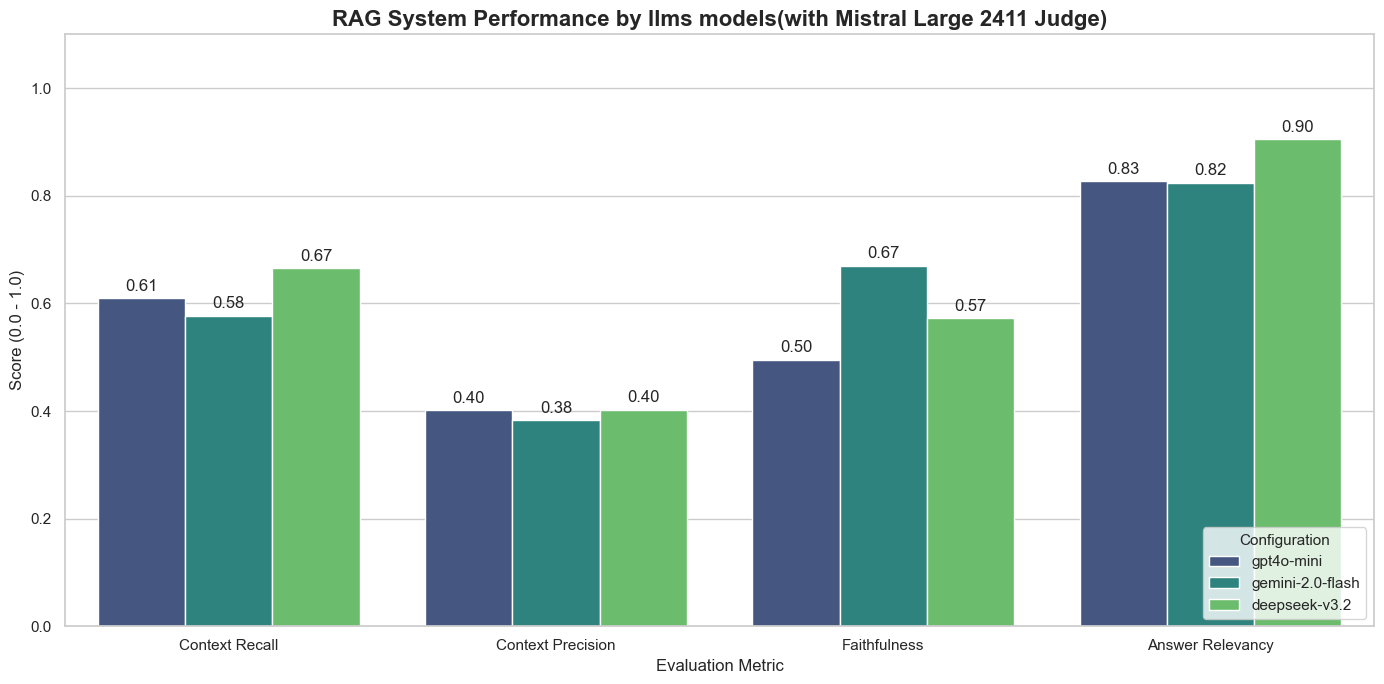

In [27]:
plot_results(final_df_LLMS_2, "RAG System Performance by llms models(with Mistral Large 2411 Judge)")

# gemini 2.5 flash, chunk sie 512 vs 256, judge temo=0.0

In [38]:
CHUNKS_FILES = {    
    "chunk 256": "results_chunk_256_overlap_50_voyage3lite_gemini25_flash_topk10_dist05_prompt_baseline.json",
    "chunk 512": "results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk10_dist05_prompt_baseline.json"}

In [39]:
all_results_chunks = calculate_all_results(CHUNKS_FILES)

starting evaluation: chunk 256 (results_chunk_256_overlap_50_voyage3lite_gemini25_flash_topk10_dist05_prompt_baseline.json)...
processing 29 questions in batch size: 1...
evaluating question 0


Evaluating: 100%|██████████| 4/4 [00:36<00:00,  9.13s/it]


evaluating question 1


Evaluating: 100%|██████████| 4/4 [00:40<00:00, 10.10s/it]


evaluating question 2


Evaluating: 100%|██████████| 4/4 [00:59<00:00, 14.76s/it]


evaluating question 3


Evaluating: 100%|██████████| 4/4 [00:29<00:00,  7.36s/it]


evaluating question 4


Evaluating: 100%|██████████| 4/4 [00:42<00:00, 10.51s/it]


evaluating question 5


Evaluating: 100%|██████████| 4/4 [00:31<00:00,  7.80s/it]


evaluating question 6


Evaluating: 100%|██████████| 4/4 [00:31<00:00,  7.95s/it]


evaluating question 7


Evaluating: 100%|██████████| 4/4 [00:35<00:00,  8.95s/it]


evaluating question 8


Evaluating: 100%|██████████| 4/4 [00:31<00:00,  7.79s/it]


evaluating question 9


Evaluating: 100%|██████████| 4/4 [01:00<00:00, 15.11s/it]


evaluating question 10


Evaluating: 100%|██████████| 4/4 [00:41<00:00, 10.27s/it]


evaluating question 11


Evaluating: 100%|██████████| 4/4 [00:48<00:00, 12.01s/it]


evaluating question 12


Evaluating: 100%|██████████| 4/4 [01:01<00:00, 15.43s/it]


evaluating question 13


Evaluating: 100%|██████████| 4/4 [00:59<00:00, 14.94s/it]


evaluating question 14


Evaluating: 100%|██████████| 4/4 [01:28<00:00, 22.22s/it]


evaluating question 15


Evaluating: 100%|██████████| 4/4 [00:52<00:00, 13.19s/it]


evaluating question 16


Evaluating: 100%|██████████| 4/4 [00:39<00:00,  9.89s/it]


evaluating question 17


Evaluating: 100%|██████████| 4/4 [00:57<00:00, 14.33s/it]


evaluating question 18


Evaluating: 100%|██████████| 4/4 [00:58<00:00, 14.54s/it]


evaluating question 19


Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.52s/it]


evaluating question 20


Evaluating: 100%|██████████| 4/4 [00:58<00:00, 14.74s/it]


evaluating question 21


Evaluating: 100%|██████████| 4/4 [00:46<00:00, 11.50s/it]


evaluating question 22


Evaluating: 100%|██████████| 4/4 [00:36<00:00,  9.21s/it]


evaluating question 23


Evaluating: 100%|██████████| 4/4 [00:41<00:00, 10.39s/it]


evaluating question 24


Evaluating: 100%|██████████| 4/4 [00:29<00:00,  7.37s/it]


evaluating question 25


Evaluating: 100%|██████████| 4/4 [00:59<00:00, 14.91s/it]


evaluating question 26


Evaluating: 100%|██████████| 4/4 [00:50<00:00, 12.52s/it]


evaluating question 27


Evaluating: 100%|██████████| 4/4 [00:56<00:00, 14.04s/it]


evaluating question 28


Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.59s/it]


evaluation complete chunk 256!
starting evaluation: chunk 512 (results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk10_dist05_prompt_baseline.json)...
processing 30 questions in batch size: 1...
evaluating question 0


Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.71s/it]


evaluating question 1


Evaluating: 100%|██████████| 4/4 [00:49<00:00, 12.33s/it]


evaluating question 2


Evaluating: 100%|██████████| 4/4 [01:05<00:00, 16.27s/it]


evaluating question 3


Evaluating: 100%|██████████| 4/4 [00:36<00:00,  9.07s/it]


evaluating question 4


Evaluating: 100%|██████████| 4/4 [00:46<00:00, 11.71s/it]


evaluating question 5


Evaluating: 100%|██████████| 4/4 [00:46<00:00, 11.71s/it]


evaluating question 6


Evaluating: 100%|██████████| 4/4 [00:22<00:00,  5.62s/it]


evaluating question 7


Evaluating: 100%|██████████| 4/4 [00:35<00:00,  8.78s/it]


evaluating question 8


Evaluating: 100%|██████████| 4/4 [00:37<00:00,  9.44s/it]


evaluating question 9


Evaluating: 100%|██████████| 4/4 [00:37<00:00,  9.44s/it]


evaluating question 10


Evaluating: 100%|██████████| 4/4 [00:33<00:00,  8.46s/it]


evaluating question 11


Evaluating: 100%|██████████| 4/4 [00:54<00:00, 13.63s/it]


evaluating question 12


Evaluating: 100%|██████████| 4/4 [01:07<00:00, 17.00s/it]


evaluating question 13


Evaluating: 100%|██████████| 4/4 [01:04<00:00, 16.13s/it]


evaluating question 14


Evaluating: 100%|██████████| 4/4 [01:13<00:00, 18.44s/it]


evaluating question 15


Evaluating: 100%|██████████| 4/4 [00:51<00:00, 12.87s/it]


evaluating question 16


Evaluating: 100%|██████████| 4/4 [00:32<00:00,  8.10s/it]


evaluating question 17


Evaluating: 100%|██████████| 4/4 [00:44<00:00, 11.19s/it]


evaluating question 18


Evaluating: 100%|██████████| 4/4 [00:43<00:00, 10.90s/it]


evaluating question 19


Evaluating: 100%|██████████| 4/4 [00:53<00:00, 13.33s/it]


evaluating question 20


Evaluating: 100%|██████████| 4/4 [01:04<00:00, 16.19s/it]


evaluating question 21


Evaluating: 100%|██████████| 4/4 [00:48<00:00, 12.21s/it]


evaluating question 22


Evaluating: 100%|██████████| 4/4 [01:02<00:00, 15.67s/it]


evaluating question 23


Evaluating: 100%|██████████| 4/4 [01:00<00:00, 15.02s/it]


evaluating question 24


Evaluating: 100%|██████████| 4/4 [00:53<00:00, 13.38s/it]


evaluating question 25


Evaluating: 100%|██████████| 4/4 [00:46<00:00, 11.74s/it]


evaluating question 26


Evaluating: 100%|██████████| 4/4 [00:47<00:00, 11.94s/it]


evaluating question 27


Evaluating: 100%|██████████| 4/4 [01:01<00:00, 15.29s/it]


evaluating question 28


Evaluating: 100%|██████████| 4/4 [01:13<00:00, 18.26s/it]


evaluating question 29


Evaluating: 100%|██████████| 4/4 [00:32<00:00,  8.18s/it]


evaluation complete chunk 512!


In [40]:
final_df_chunks = save_and_summarize_results(all_results_chunks, filename="RAG_Analysis_small_chunks_results.xlsx")


 Results saved to RAG_Analysis_small_chunks_results.xlsx

--- Average Scores ---


,context_recall,context_precision,faithfulness,answer_relevancy
Config,,,,
chunk 256,0.708826,0.431314,0.930655,0.786498
chunk 512,0.732381,0.578037,0.906209,0.735875


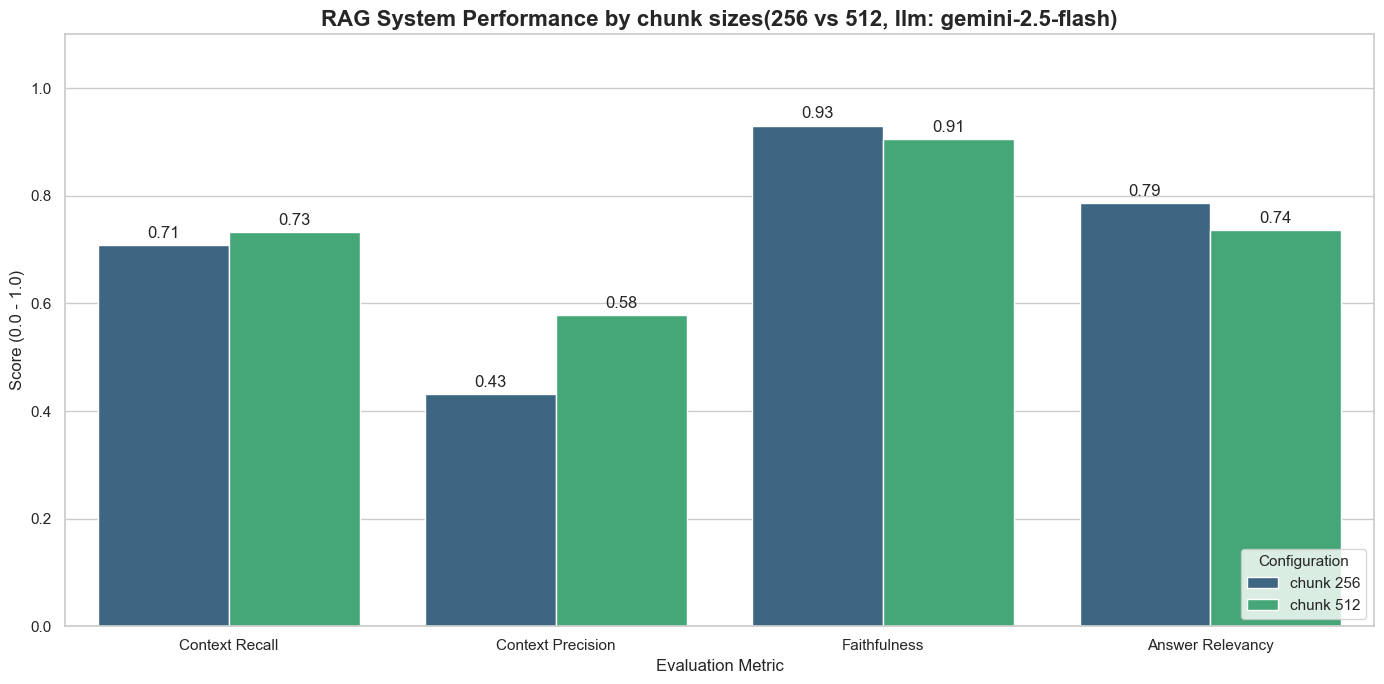

In [41]:
plot_results(final_df_chunks, "RAG System Performance by chunk sizes(256 vs 512, llm: gemini-2.5-flash)")

# gemini test 2.0 vs 2.5

In [42]:
GEMINI_FILES = {    
    "gemini 2.0 flash": "results_chunk_512_overlap_100_voyage3lite_gemini20_flash_topk10_dist05_prompt_baseline.json"}

In [50]:
all_results_gemini20 = calculate_all_results(GEMINI_FILES)

starting evaluation: gemini 2.0 flash (results_chunk_512_overlap_100_voyage3lite_gemini20_flash_topk10_dist05_prompt_baseline.json)...
processing 30 questions in batch size: 1...
evaluating question 0


Evaluating: 100%|██████████| 4/4 [00:27<00:00,  6.77s/it]


evaluating question 1


Evaluating: 100%|██████████| 4/4 [00:37<00:00,  9.43s/it]


evaluating question 2


Evaluating: 100%|██████████| 4/4 [00:56<00:00, 14.23s/it]


evaluating question 3


Evaluating: 100%|██████████| 4/4 [00:32<00:00,  8.02s/it]


evaluating question 4


Evaluating: 100%|██████████| 4/4 [00:36<00:00,  9.19s/it]


evaluating question 5


Evaluating: 100%|██████████| 4/4 [00:35<00:00,  8.75s/it]


evaluating question 6


Evaluating: 100%|██████████| 4/4 [00:19<00:00,  4.78s/it]


evaluating question 7


Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.52s/it]


evaluating question 8


Evaluating: 100%|██████████| 4/4 [00:21<00:00,  5.38s/it]


evaluating question 9


Evaluating: 100%|██████████| 4/4 [00:36<00:00,  9.18s/it]


evaluating question 10


Evaluating: 100%|██████████| 4/4 [00:26<00:00,  6.61s/it]


evaluating question 11


Evaluating: 100%|██████████| 4/4 [00:39<00:00,  9.76s/it]


evaluating question 12


Evaluating: 100%|██████████| 4/4 [00:56<00:00, 14.16s/it]


evaluating question 13


Evaluating: 100%|██████████| 4/4 [00:44<00:00, 11.07s/it]


evaluating question 14


Evaluating: 100%|██████████| 4/4 [00:58<00:00, 14.66s/it]


evaluating question 15


Evaluating: 100%|██████████| 4/4 [01:05<00:00, 16.44s/it]


evaluating question 16


Evaluating: 100%|██████████| 4/4 [00:35<00:00,  8.78s/it]


evaluating question 17


Evaluating: 100%|██████████| 4/4 [00:37<00:00,  9.48s/it]


evaluating question 18


Evaluating: 100%|██████████| 4/4 [00:19<00:00,  4.96s/it]


evaluating question 19


Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.74s/it]


evaluating question 20


Evaluating: 100%|██████████| 4/4 [00:35<00:00,  8.93s/it]


evaluating question 21


Evaluating: 100%|██████████| 4/4 [00:30<00:00,  7.60s/it]


evaluating question 22


Evaluating: 100%|██████████| 4/4 [00:46<00:00, 11.70s/it]


evaluating question 23


Evaluating: 100%|██████████| 4/4 [00:37<00:00,  9.30s/it]


evaluating question 24


Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.65s/it]


evaluating question 25


Evaluating: 100%|██████████| 4/4 [00:35<00:00,  8.80s/it]


evaluating question 26


Evaluating: 100%|██████████| 4/4 [00:43<00:00, 10.75s/it]


evaluating question 27


Evaluating: 100%|██████████| 4/4 [01:10<00:00, 17.58s/it]


evaluating question 28


Evaluating: 100%|██████████| 4/4 [01:01<00:00, 15.43s/it]


evaluating question 29


Evaluating: 100%|██████████| 4/4 [00:37<00:00,  9.38s/it]


evaluation complete gemini 2.0 flash!


In [51]:
final_df_gemini20 = save_and_summarize_results(all_results_gemini20, filename="RAG_Analysis_gemini20_results.xlsx")


 Results saved to RAG_Analysis_gemini20_results.xlsx

--- Average Scores ---


,context_recall,context_precision,faithfulness,answer_relevancy
Config,,,,
gemini 2.0 flash,0.739722,0.509846,0.850999,0.824557


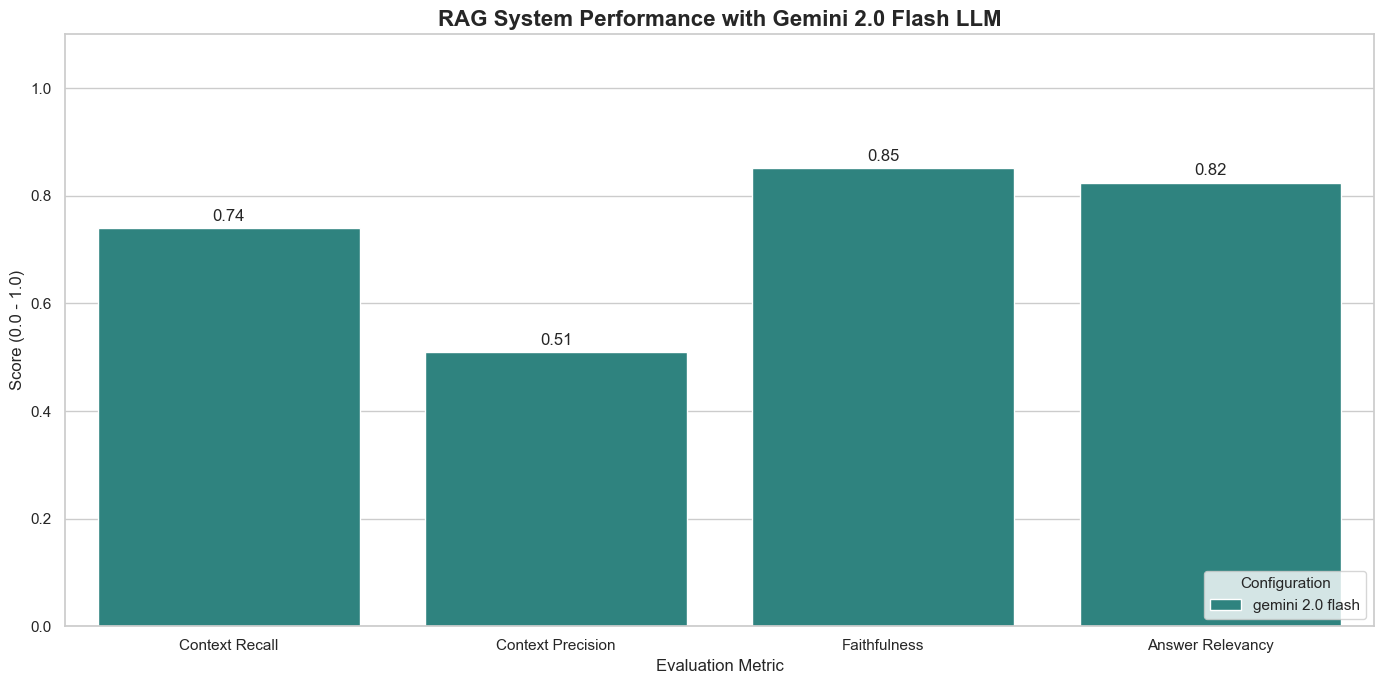

In [52]:
plot_results(final_df_gemini20, "RAG System Performance with Gemini 2.0 Flash LLM")

# test top k 

In [53]:
TOPK_FILES = {    
    "top k = 10": "results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk10_dist08_prompt_baseline.json",
    "top k = 5": "results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk5_dist08_prompt_baseline.json",
    "top k = 3": "results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk3_dist08_prompt_baseline.json"}

In [54]:
all_results_topk = calculate_all_results(TOPK_FILES)

starting evaluation: top k = 10 (results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk10_dist08_prompt_baseline.json)...
processing 30 questions in batch size: 1...
evaluating question 0


Evaluating: 100%|██████████| 4/4 [00:44<00:00, 11.11s/it]


evaluating question 1


Evaluating: 100%|██████████| 4/4 [00:54<00:00, 13.59s/it]


evaluating question 2


Evaluating: 100%|██████████| 4/4 [00:58<00:00, 14.56s/it]


evaluating question 3


Evaluating: 100%|██████████| 4/4 [00:30<00:00,  7.54s/it]


evaluating question 4


Evaluating: 100%|██████████| 4/4 [00:41<00:00, 10.40s/it]


evaluating question 5


Evaluating: 100%|██████████| 4/4 [00:33<00:00,  8.26s/it]


evaluating question 6


Evaluating: 100%|██████████| 4/4 [00:39<00:00,  9.95s/it]


evaluating question 7


Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.66s/it]


evaluating question 8


Evaluating: 100%|██████████| 4/4 [00:40<00:00, 10.21s/it]


evaluating question 9


Evaluating: 100%|██████████| 4/4 [00:35<00:00,  8.85s/it]


evaluating question 10


Evaluating: 100%|██████████| 4/4 [00:41<00:00, 10.36s/it]


evaluating question 11


Evaluating: 100%|██████████| 4/4 [00:54<00:00, 13.51s/it]


evaluating question 12


Evaluating: 100%|██████████| 4/4 [00:54<00:00, 13.64s/it]


evaluating question 13


Evaluating: 100%|██████████| 4/4 [00:56<00:00, 14.09s/it]


evaluating question 14


Evaluating: 100%|██████████| 4/4 [00:58<00:00, 14.73s/it]


evaluating question 15


Evaluating: 100%|██████████| 4/4 [01:05<00:00, 16.34s/it]


evaluating question 16


Evaluating: 100%|██████████| 4/4 [00:43<00:00, 10.85s/it]


evaluating question 17


Evaluating: 100%|██████████| 4/4 [00:40<00:00, 10.19s/it]


evaluating question 18


Evaluating: 100%|██████████| 4/4 [00:53<00:00, 13.44s/it]


evaluating question 19


Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.68s/it]


evaluating question 20


Evaluating: 100%|██████████| 4/4 [00:51<00:00, 12.86s/it]


evaluating question 21


Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.74s/it]


evaluating question 22


Evaluating: 100%|██████████| 4/4 [00:53<00:00, 13.46s/it]


evaluating question 23


Evaluating: 100%|██████████| 4/4 [00:45<00:00, 11.34s/it]


evaluating question 24


Evaluating: 100%|██████████| 4/4 [00:44<00:00, 11.25s/it]


evaluating question 25


Evaluating: 100%|██████████| 4/4 [00:42<00:00, 10.54s/it]


evaluating question 26


Evaluating: 100%|██████████| 4/4 [00:51<00:00, 12.87s/it]


evaluating question 27


Evaluating: 100%|██████████| 4/4 [01:05<00:00, 16.41s/it]


evaluating question 28


Evaluating: 100%|██████████| 4/4 [00:56<00:00, 14.21s/it]


evaluating question 29


Evaluating: 100%|██████████| 4/4 [00:43<00:00, 10.92s/it]


evaluation complete top k = 10!
starting evaluation: top k = 5 (results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk5_dist08_prompt_baseline.json)...
processing 30 questions in batch size: 1...
evaluating question 0


Evaluating: 100%|██████████| 4/4 [00:36<00:00,  9.18s/it]


evaluating question 1


Evaluating: 100%|██████████| 4/4 [00:51<00:00, 12.77s/it]


evaluating question 2


Evaluating: 100%|██████████| 4/4 [00:46<00:00, 11.68s/it]


evaluating question 3


Evaluating: 100%|██████████| 4/4 [00:32<00:00,  8.18s/it]


evaluating question 4


Evaluating: 100%|██████████| 4/4 [00:53<00:00, 13.32s/it]


evaluating question 5


Evaluating: 100%|██████████| 4/4 [00:44<00:00, 11.01s/it]


evaluating question 6


Evaluating: 100%|██████████| 4/4 [00:26<00:00,  6.67s/it]


evaluating question 7


Evaluating: 100%|██████████| 4/4 [00:31<00:00,  7.80s/it]


evaluating question 8


Evaluating: 100%|██████████| 4/4 [00:36<00:00,  9.21s/it]


evaluating question 9


Evaluating: 100%|██████████| 4/4 [01:00<00:00, 15.20s/it]


evaluating question 10


Evaluating: 100%|██████████| 4/4 [00:48<00:00, 12.01s/it]


evaluating question 11


Evaluating: 100%|██████████| 4/4 [01:04<00:00, 16.08s/it]


evaluating question 12


Evaluating: 100%|██████████| 4/4 [01:18<00:00, 19.73s/it]


evaluating question 13


Evaluating: 100%|██████████| 4/4 [01:00<00:00, 15.00s/it]


evaluating question 14


Evaluating: 100%|██████████| 4/4 [01:01<00:00, 15.45s/it]


evaluating question 15


Evaluating: 100%|██████████| 4/4 [00:50<00:00, 12.57s/it]


evaluating question 16


Evaluating: 100%|██████████| 4/4 [00:33<00:00,  8.33s/it]


evaluating question 17


Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.57s/it]


evaluating question 18


Evaluating: 100%|██████████| 4/4 [00:36<00:00,  9.09s/it]


evaluating question 19


Evaluating: 100%|██████████| 4/4 [01:01<00:00, 15.44s/it]


evaluating question 20


Evaluating: 100%|██████████| 4/4 [00:50<00:00, 12.56s/it]


evaluating question 21


Evaluating: 100%|██████████| 4/4 [00:31<00:00,  7.83s/it]


evaluating question 22


Evaluating: 100%|██████████| 4/4 [00:59<00:00, 14.88s/it]


evaluating question 23


Evaluating: 100%|██████████| 4/4 [01:13<00:00, 18.43s/it]


evaluating question 24


Evaluating: 100%|██████████| 4/4 [00:53<00:00, 13.26s/it]


evaluating question 25


Evaluating: 100%|██████████| 4/4 [00:18<00:00,  4.75s/it]


evaluating question 26


Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.63s/it]


evaluating question 27


Evaluating: 100%|██████████| 4/4 [01:17<00:00, 19.30s/it]


evaluating question 28


Evaluating: 100%|██████████| 4/4 [01:03<00:00, 15.83s/it]


evaluating question 29


Evaluating: 100%|██████████| 4/4 [00:49<00:00, 12.25s/it]


evaluation complete top k = 5!
starting evaluation: top k = 3 (results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk3_dist08_prompt_baseline.json)...
processing 30 questions in batch size: 1...
evaluating question 0


Evaluating: 100%|██████████| 4/4 [00:28<00:00,  7.10s/it]


evaluating question 1


Evaluating: 100%|██████████| 4/4 [00:51<00:00, 12.84s/it]


evaluating question 2


Evaluating: 100%|██████████| 4/4 [00:57<00:00, 14.29s/it]


evaluating question 3


Evaluating: 100%|██████████| 4/4 [00:40<00:00, 10.13s/it]


evaluating question 4


Evaluating: 100%|██████████| 4/4 [00:46<00:00, 11.73s/it]


evaluating question 5


Evaluating: 100%|██████████| 4/4 [00:48<00:00, 12.04s/it]


evaluating question 6


Evaluating: 100%|██████████| 4/4 [00:30<00:00,  7.63s/it]


evaluating question 7


Evaluating: 100%|██████████| 4/4 [00:26<00:00,  6.56s/it]


evaluating question 8


Evaluating: 100%|██████████| 4/4 [00:48<00:00, 12.02s/it]


evaluating question 9


Evaluating: 100%|██████████| 4/4 [00:41<00:00, 10.33s/it]


evaluating question 10


Evaluating: 100%|██████████| 4/4 [00:48<00:00, 12.19s/it]


evaluating question 11


Evaluating: 100%|██████████| 4/4 [00:47<00:00, 11.78s/it]


evaluating question 12


Evaluating: 100%|██████████| 4/4 [01:02<00:00, 15.68s/it]


evaluating question 13


Evaluating: 100%|██████████| 4/4 [00:48<00:00, 12.08s/it]


evaluating question 14


Evaluating: 100%|██████████| 4/4 [01:02<00:00, 15.70s/it]


evaluating question 15


Evaluating: 100%|██████████| 4/4 [00:49<00:00, 12.32s/it]


evaluating question 16


Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.57s/it]


evaluating question 17


Evaluating: 100%|██████████| 4/4 [00:52<00:00, 13.06s/it]


evaluating question 18


Evaluating: 100%|██████████| 4/4 [00:40<00:00, 10.20s/it]


evaluating question 19


Evaluating: 100%|██████████| 4/4 [00:42<00:00, 10.71s/it]


evaluating question 20


Evaluating: 100%|██████████| 4/4 [00:29<00:00,  7.42s/it]


evaluating question 21


Evaluating: 100%|██████████| 4/4 [00:25<00:00,  6.37s/it]


evaluating question 22


Evaluating: 100%|██████████| 4/4 [01:04<00:00, 16.19s/it]


evaluating question 23


Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.64s/it]


evaluating question 24


Evaluating: 100%|██████████| 4/4 [00:47<00:00, 11.99s/it]


evaluating question 25


Evaluating: 100%|██████████| 4/4 [00:26<00:00,  6.57s/it]


evaluating question 26


Evaluating: 100%|██████████| 4/4 [00:40<00:00, 10.07s/it]


evaluating question 27


Evaluating: 100%|██████████| 4/4 [01:03<00:00, 15.88s/it]


evaluating question 28


Evaluating: 100%|██████████| 4/4 [00:52<00:00, 13.12s/it]


evaluating question 29


Evaluating: 100%|██████████| 4/4 [00:44<00:00, 11.15s/it]


evaluation complete top k = 3!


In [55]:
final_df_topk = save_and_summarize_results(all_results_topk, filename="RAG_Analysis_topk_results.xlsx")


 Results saved to RAG_Analysis_topk_results.xlsx

--- Average Scores ---


,context_recall,context_precision,faithfulness,answer_relevancy
Config,,,,
top k = 10,0.762209,0.435888,0.942044,0.775929
top k = 3,0.546455,0.666667,0.823240,0.664792
top k = 5,0.730384,0.612731,0.922651,0.689039


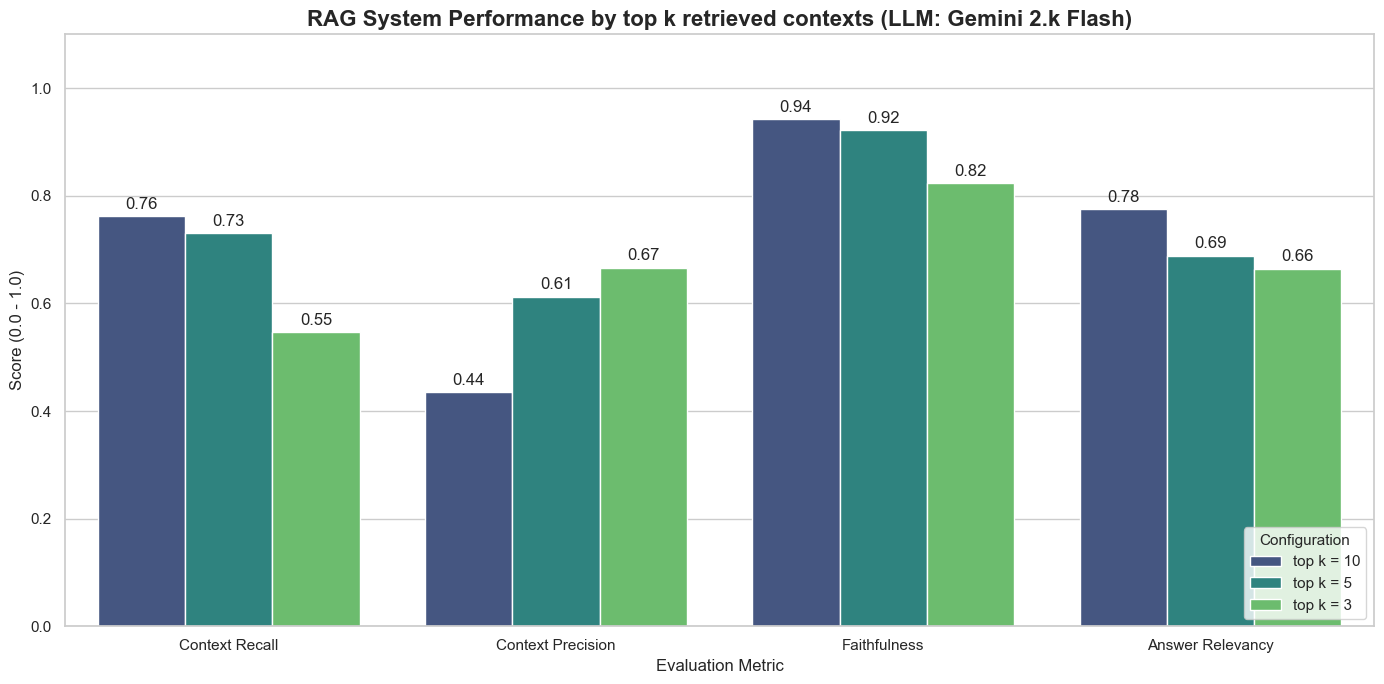

In [56]:
plot_results(final_df_topk, "RAG System Performance by top k retrieved contexts (LLM: Gemini 2.k Flash)")

# test threshold

In [57]:
THRESHOLD_FILES = {    
    "threshold = 0.6": "results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk10_dist06_prompt_baseline.json",
    "threshlod = 0.45": "results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk5_dist045_prompt_baseline.json"}

In [58]:
all_results_threshold = calculate_all_results(THRESHOLD_FILES)

starting evaluation: threshold = 0.6 (results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk10_dist06_prompt_baseline.json)...
processing 30 questions in batch size: 1...
evaluating question 0


Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.61s/it]


evaluating question 1


Evaluating: 100%|██████████| 4/4 [01:16<00:00, 19.13s/it]


evaluating question 2


Evaluating: 100%|██████████| 4/4 [01:10<00:00, 17.72s/it]


evaluating question 3


Evaluating: 100%|██████████| 4/4 [00:32<00:00,  8.18s/it]


evaluating question 4


Evaluating: 100%|██████████| 4/4 [00:46<00:00, 11.50s/it]


evaluating question 5


Evaluating: 100%|██████████| 4/4 [00:45<00:00, 11.29s/it]


evaluating question 6


Evaluating: 100%|██████████| 4/4 [00:35<00:00,  8.91s/it]


evaluating question 7


Evaluating: 100%|██████████| 4/4 [00:35<00:00,  8.90s/it]


evaluating question 8


Evaluating: 100%|██████████| 4/4 [00:47<00:00, 11.94s/it]


evaluating question 9


Evaluating: 100%|██████████| 4/4 [00:47<00:00, 11.79s/it]


evaluating question 10


Evaluating: 100%|██████████| 4/4 [00:43<00:00, 11.00s/it]


evaluating question 11


Evaluating: 100%|██████████| 4/4 [01:10<00:00, 17.65s/it]


evaluating question 12


Evaluating: 100%|██████████| 4/4 [01:13<00:00, 18.31s/it]


evaluating question 13


Evaluating: 100%|██████████| 4/4 [01:59<00:00, 29.94s/it]


evaluating question 14


Evaluating: 100%|██████████| 4/4 [01:13<00:00, 18.50s/it]


evaluating question 15


Evaluating: 100%|██████████| 4/4 [01:00<00:00, 15.15s/it]


evaluating question 16


Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.61s/it]


evaluating question 17


Evaluating: 100%|██████████| 4/4 [01:00<00:00, 15.03s/it]


evaluating question 18


Evaluating: 100%|██████████| 4/4 [00:49<00:00, 12.49s/it]


evaluating question 19


Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.65s/it]


evaluating question 20


Evaluating: 100%|██████████| 4/4 [00:55<00:00, 13.82s/it]


evaluating question 21


Evaluating: 100%|██████████| 4/4 [00:48<00:00, 12.10s/it]


evaluating question 22


Evaluating: 100%|██████████| 4/4 [01:09<00:00, 17.29s/it]


evaluating question 23


Evaluating: 100%|██████████| 4/4 [00:59<00:00, 14.77s/it]


evaluating question 24


Evaluating: 100%|██████████| 4/4 [00:37<00:00,  9.50s/it]


evaluating question 25


Evaluating: 100%|██████████| 4/4 [00:51<00:00, 12.77s/it]


evaluating question 26


Evaluating: 100%|██████████| 4/4 [00:42<00:00, 10.65s/it]


evaluating question 27


Evaluating: 100%|██████████| 4/4 [00:59<00:00, 14.96s/it]


evaluating question 28


Evaluating: 100%|██████████| 4/4 [00:47<00:00, 11.81s/it]


evaluating question 29


Evaluating: 100%|██████████| 4/4 [00:37<00:00,  9.44s/it]


evaluation complete threshold = 0.6!
starting evaluation: threshlod = 0.45 (results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk5_dist045_prompt_baseline.json)...
file not found: results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk5_dist045_prompt_baseline.json


In [61]:
final_df_threshold_1 = save_and_summarize_results(all_results_threshold, filename="RAG_Analysis_threshold_results_1.xlsx")


 Results saved to RAG_Analysis_threshold_results_1.xlsx

--- Average Scores ---


,context_recall,context_precision,faithfulness,answer_relevancy
Config,,,,
threshold = 0.6,0.764683,0.454496,0.924786,0.816786


In [62]:
THRESHOLD_FILES_2 = {    
    "threshlod = 0.45": "results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk10_dist045_prompt_baseline.json"}

In [65]:
all_results_threshold_2 = calculate_all_results(THRESHOLD_FILES_2)

starting evaluation: threshlod = 0.45 (results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk10_dist045_prompt_baseline.json)...
processing 30 questions in batch size: 1...
evaluating question 0


Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.64s/it]


evaluating question 1


Evaluating: 100%|██████████| 4/4 [00:41<00:00, 10.36s/it]


evaluating question 2


Evaluating: 100%|██████████| 4/4 [00:47<00:00, 11.78s/it]


evaluating question 3


Evaluating: 100%|██████████| 4/4 [00:29<00:00,  7.37s/it]


evaluating question 4


Evaluating: 100%|██████████| 4/4 [00:39<00:00,  9.78s/it]


evaluating question 5


Evaluating: 100%|██████████| 4/4 [00:43<00:00, 10.94s/it]


evaluating question 6


Evaluating: 100%|██████████| 4/4 [00:18<00:00,  4.56s/it]


evaluating question 7


Evaluating: 100%|██████████| 4/4 [00:33<00:00,  8.38s/it]


evaluating question 8


Evaluating: 100%|██████████| 4/4 [00:45<00:00, 11.44s/it]


evaluating question 9


Evaluating: 100%|██████████| 4/4 [00:26<00:00,  6.60s/it]


evaluating question 10


Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.68s/it]


evaluating question 11


Evaluating: 100%|██████████| 4/4 [00:58<00:00, 14.56s/it]


evaluating question 12


Evaluating: 100%|██████████| 4/4 [01:03<00:00, 15.95s/it]


evaluating question 13


Evaluating: 100%|██████████| 4/4 [01:04<00:00, 16.17s/it]


evaluating question 14


Evaluating: 100%|██████████| 4/4 [01:16<00:00, 19.20s/it]


evaluating question 15


Evaluating: 100%|██████████| 4/4 [01:03<00:00, 15.86s/it]


evaluating question 16


Evaluating: 100%|██████████| 4/4 [00:30<00:00,  7.68s/it]


evaluating question 17


Evaluating: 100%|██████████| 4/4 [00:39<00:00,  9.80s/it]


evaluating question 18


Evaluating: 100%|██████████| 4/4 [00:41<00:00, 10.37s/it]


evaluating question 19


Evaluating: 100%|██████████| 4/4 [00:44<00:00, 11.19s/it]


evaluating question 20


Evaluating: 100%|██████████| 4/4 [00:38<00:00,  9.70s/it]


evaluating question 21


Evaluating: 100%|██████████| 4/4 [00:41<00:00, 10.42s/it]


evaluating question 22


Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.71s/it]


evaluating question 23


Evaluating: 100%|██████████| 4/4 [00:48<00:00, 12.20s/it]


evaluating question 24


Evaluating: 100%|██████████| 4/4 [00:42<00:00, 10.53s/it]


evaluating question 25


Evaluating: 100%|██████████| 4/4 [00:23<00:00,  5.96s/it]


evaluating question 26


Evaluating: 100%|██████████| 4/4 [00:50<00:00, 12.75s/it]


evaluating question 27


Evaluating: 100%|██████████| 4/4 [01:13<00:00, 18.28s/it]


evaluating question 28


Evaluating: 100%|██████████| 4/4 [00:58<00:00, 14.73s/it]


evaluating question 29


Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.58s/it]


evaluation complete threshlod = 0.45!


In [66]:
final_df_threshold_2 = save_and_summarize_results(all_results_threshold_2, filename="RAG_Analysis_threshold_results_2.xlsx")


 Results saved to RAG_Analysis_threshold_results_2.xlsx

--- Average Scores ---


,context_recall,context_precision,faithfulness,answer_relevancy
Config,,,,
threshlod = 0.45,0.723452,0.630192,0.924051,0.650947


In [71]:
THRESHOLD_FILES_3 = {    
    "threshold = 0.55": "results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk10_dist055_prompt_baseline.json"}

In [72]:
all_results_threshold_3 = calculate_all_results(THRESHOLD_FILES_3)

starting evaluation: threshold = 0.55 (results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk10_dist055_prompt_baseline.json)...
processing 30 questions in batch size: 1...
evaluating question 0


Evaluating: 100%|██████████| 4/4 [00:35<00:00,  8.89s/it]


evaluating question 1


Evaluating: 100%|██████████| 4/4 [00:39<00:00,  9.82s/it]


evaluating question 2


Evaluating: 100%|██████████| 4/4 [01:02<00:00, 15.73s/it]


evaluating question 3


Evaluating: 100%|██████████| 4/4 [00:32<00:00,  8.09s/it]


evaluating question 4


Evaluating: 100%|██████████| 4/4 [00:48<00:00, 12.20s/it]


evaluating question 5


Evaluating: 100%|██████████| 4/4 [00:45<00:00, 11.48s/it]


evaluating question 6


Evaluating: 100%|██████████| 4/4 [00:35<00:00,  8.86s/it]


evaluating question 7


Evaluating: 100%|██████████| 4/4 [00:33<00:00,  8.36s/it]


evaluating question 8


Evaluating: 100%|██████████| 4/4 [00:30<00:00,  7.53s/it]


evaluating question 9


Evaluating: 100%|██████████| 4/4 [00:34<00:00,  8.58s/it]


evaluating question 10


Evaluating: 100%|██████████| 4/4 [00:39<00:00,  9.76s/it]


evaluating question 11


Evaluating: 100%|██████████| 4/4 [00:56<00:00, 14.11s/it]


evaluating question 12


Evaluating: 100%|██████████| 4/4 [01:11<00:00, 17.76s/it]


evaluating question 13


Evaluating: 100%|██████████| 4/4 [01:18<00:00, 19.52s/it]


evaluating question 14


Evaluating: 100%|██████████| 4/4 [01:23<00:00, 20.79s/it]


evaluating question 15


Evaluating: 100%|██████████| 4/4 [01:11<00:00, 17.80s/it]


evaluating question 16


Evaluating: 100%|██████████| 4/4 [00:33<00:00,  8.41s/it]


evaluating question 17


Evaluating: 100%|██████████| 4/4 [00:39<00:00,  9.98s/it]


evaluating question 18


Evaluating: 100%|██████████| 4/4 [00:42<00:00, 10.56s/it]


evaluating question 19


Evaluating: 100%|██████████| 4/4 [00:46<00:00, 11.53s/it]


evaluating question 20


Evaluating: 100%|██████████| 4/4 [00:53<00:00, 13.47s/it]


evaluating question 21


Evaluating: 100%|██████████| 4/4 [00:44<00:00, 11.02s/it]


evaluating question 22


Evaluating: 100%|██████████| 4/4 [01:02<00:00, 15.61s/it]


evaluating question 23


Evaluating: 100%|██████████| 4/4 [00:55<00:00, 13.86s/it]


evaluating question 24


Evaluating: 100%|██████████| 4/4 [00:42<00:00, 10.61s/it]


evaluating question 25


Evaluating: 100%|██████████| 4/4 [00:46<00:00, 11.58s/it]


evaluating question 26


Evaluating: 100%|██████████| 4/4 [00:56<00:00, 14.07s/it]


evaluating question 27


Evaluating: 100%|██████████| 4/4 [01:24<00:00, 21.17s/it]


evaluating question 28


Evaluating: 100%|██████████| 4/4 [00:58<00:00, 14.53s/it]


evaluating question 29


Evaluating: 100%|██████████| 4/4 [00:43<00:00, 10.89s/it]


evaluation complete threshold = 0.55!


In [73]:
final_df_threshold_3 = save_and_summarize_results(all_results_threshold_3, filename="RAG_Analysis_threshold_results_3.xlsx")


 Results saved to RAG_Analysis_threshold_results_3.xlsx

--- Average Scores ---


,context_recall,context_precision,faithfulness,answer_relevancy
Config,,,,
threshold = 0.55,0.756085,0.442081,0.925321,0.743068


In [67]:
final_df_threshold = pd.concat([final_df_threshold_1, final_df_threshold_2], ignore_index=True)

In [ ]:
import pandas as pd
try:
    df_topk = pd.read_excel("RAG_Analysis_topk_results.xlsx")
    df_chunks = pd.read_excel("RAG_Analysis_small_chunks_results.xlsx")
except FileNotFoundError:
    df_topk = pd.read_csv("RAG_Analysis_topk_results.csv")
    df_chunks = pd.read_csv("RAG_Analysis_small_chunks_results.csv")

# Wyciągnięcie i edycja danych dla top k = 10 -> threshold = 0.8
subset_topk_10 = df_topk[df_topk['Config'].astype(str).str.contains("top k = 10", case=False)].copy()
subset_topk_10['Config'] = "threshold = 0.8"

# Wyciągnięcie i edycja danych dla chunk 512 -> threshold = 0.5
subset_chunk_512 = df_chunks[df_chunks['Config'].astype(str).str.contains("chunk 512", case=False)].copy()
subset_chunk_512['Config'] = "threshold = 0.5"

final_df_combined = pd.concat([final_df_threshold_2, subset_chunk_512, final_df_threshold_3, final_df_threshold_1, subset_topk_10], ignore_index=True)

output_filename = "RAG_Analysis_threshold_results_final.xlsx"
final_df_combined.to_excel(output_filename, index=False)


print(f"Dodano {len(subset_topk_10)} wierszy z top k=10 oraz {len(subset_chunk_512)} wierszy z chunk 512.")

Dodano 30 wierszy z top k=10 oraz 30 wierszy z chunk 512.


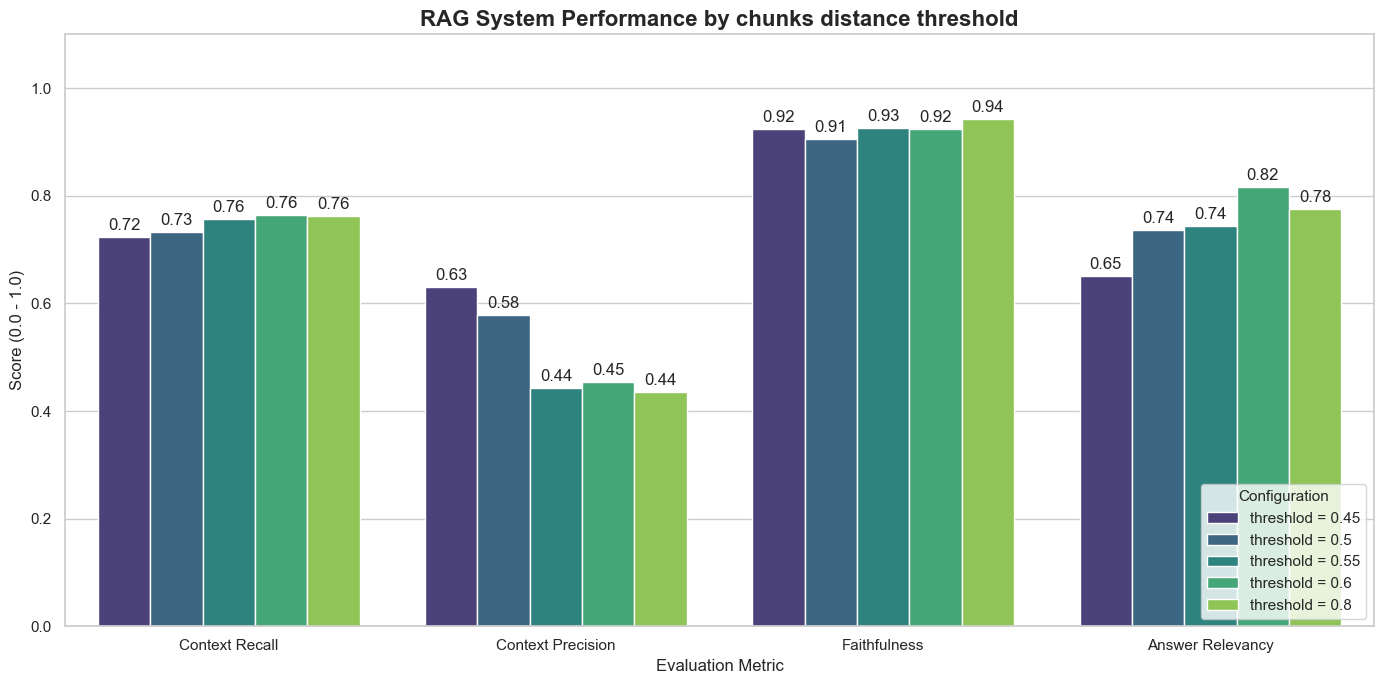

In [75]:
plot_results(final_df_combined, "RAG System Performance by chunks distance threshold")

In [82]:
TEMPERATURE_FILES = {    
    "temperature = 0.7": "results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk10_dist05_temp07.json"}

In [83]:
all_results_temperature = calculate_all_results(TEMPERATURE_FILES)

starting evaluation: temperature = 0.7 (results_chunk_512_overlap_100_voyage3lite_gemini25_flash_topk10_dist05_temp07.json)...
processing 30 questions in batch size: 1...
evaluating question 0


Evaluating: 100%|██████████| 4/4 [00:47<00:00, 11.89s/it]


evaluating question 1


Evaluating: 100%|██████████| 4/4 [00:53<00:00, 13.28s/it]


evaluating question 2


Evaluating: 100%|██████████| 4/4 [00:57<00:00, 14.27s/it]


evaluating question 3


Evaluating: 100%|██████████| 4/4 [00:31<00:00,  7.79s/it]


evaluating question 4


Evaluating: 100%|██████████| 4/4 [00:49<00:00, 12.50s/it]


evaluating question 5


Evaluating: 100%|██████████| 4/4 [01:03<00:00, 15.89s/it]


evaluating question 6


Evaluating: 100%|██████████| 4/4 [00:27<00:00,  6.83s/it]


evaluating question 7


Evaluating: 100%|██████████| 4/4 [00:36<00:00,  9.19s/it]


evaluating question 8


Evaluating: 100%|██████████| 4/4 [00:52<00:00, 13.13s/it]


evaluating question 9


Evaluating: 100%|██████████| 4/4 [01:06<00:00, 16.59s/it]


evaluating question 10


Evaluating: 100%|██████████| 4/4 [00:42<00:00, 10.59s/it]


evaluating question 11


Evaluating: 100%|██████████| 4/4 [01:37<00:00, 24.31s/it]


evaluating question 12


Evaluating: 100%|██████████| 4/4 [01:01<00:00, 15.31s/it]


evaluating question 13


Evaluating: 100%|██████████| 4/4 [01:41<00:00, 25.45s/it]


evaluating question 14


Evaluating: 100%|██████████| 4/4 [01:06<00:00, 16.74s/it]


evaluating question 15


Evaluating: 100%|██████████| 4/4 [01:10<00:00, 17.74s/it]


evaluating question 16


Evaluating: 100%|██████████| 4/4 [00:37<00:00,  9.39s/it]


evaluating question 17


Evaluating: 100%|██████████| 4/4 [00:49<00:00, 12.28s/it]


evaluating question 18


Evaluating: 100%|██████████| 4/4 [00:58<00:00, 14.57s/it]


evaluating question 19


Evaluating: 100%|██████████| 4/4 [00:58<00:00, 14.66s/it]


evaluating question 20


Evaluating: 100%|██████████| 4/4 [00:45<00:00, 11.45s/it]


evaluating question 21


Evaluating: 100%|██████████| 4/4 [00:56<00:00, 14.05s/it]


evaluating question 22


Evaluating: 100%|██████████| 4/4 [01:09<00:00, 17.46s/it]


evaluating question 23


Evaluating: 100%|██████████| 4/4 [00:43<00:00, 10.89s/it]


evaluating question 24


Evaluating: 100%|██████████| 4/4 [00:47<00:00, 11.80s/it]


evaluating question 25


Evaluating: 100%|██████████| 4/4 [00:57<00:00, 14.47s/it]


evaluating question 26


Evaluating: 100%|██████████| 4/4 [00:45<00:00, 11.29s/it]


evaluating question 27


Evaluating: 100%|██████████| 4/4 [01:12<00:00, 18.18s/it]


evaluating question 28


Evaluating: 100%|██████████| 4/4 [01:04<00:00, 16.12s/it]


evaluating question 29


Evaluating: 100%|██████████| 4/4 [00:45<00:00, 11.31s/it]


evaluation complete temperature = 0.7!


In [84]:
final_df_temperature_07 = save_and_summarize_results(all_results_temperature, filename="RAG_Analysis_threshold_temperture.xlsx")


 Results saved to RAG_Analysis_threshold_temperture.xlsx

--- Average Scores ---


,context_recall,context_precision,faithfulness,answer_relevancy
Config,,,,
temperature = 0.7,0.739722,0.565062,0.937246,0.757741


In [85]:
subset_chunk_512 = df_chunks[df_chunks['Config'].astype(str).str.contains("chunk 512", case=False)].copy()
subset_chunk_512['Config'] = "temperature = 0.1"

In [86]:
final_df_temperature = pd.concat([final_df_temperature_07, subset_chunk_512], ignore_index=True)

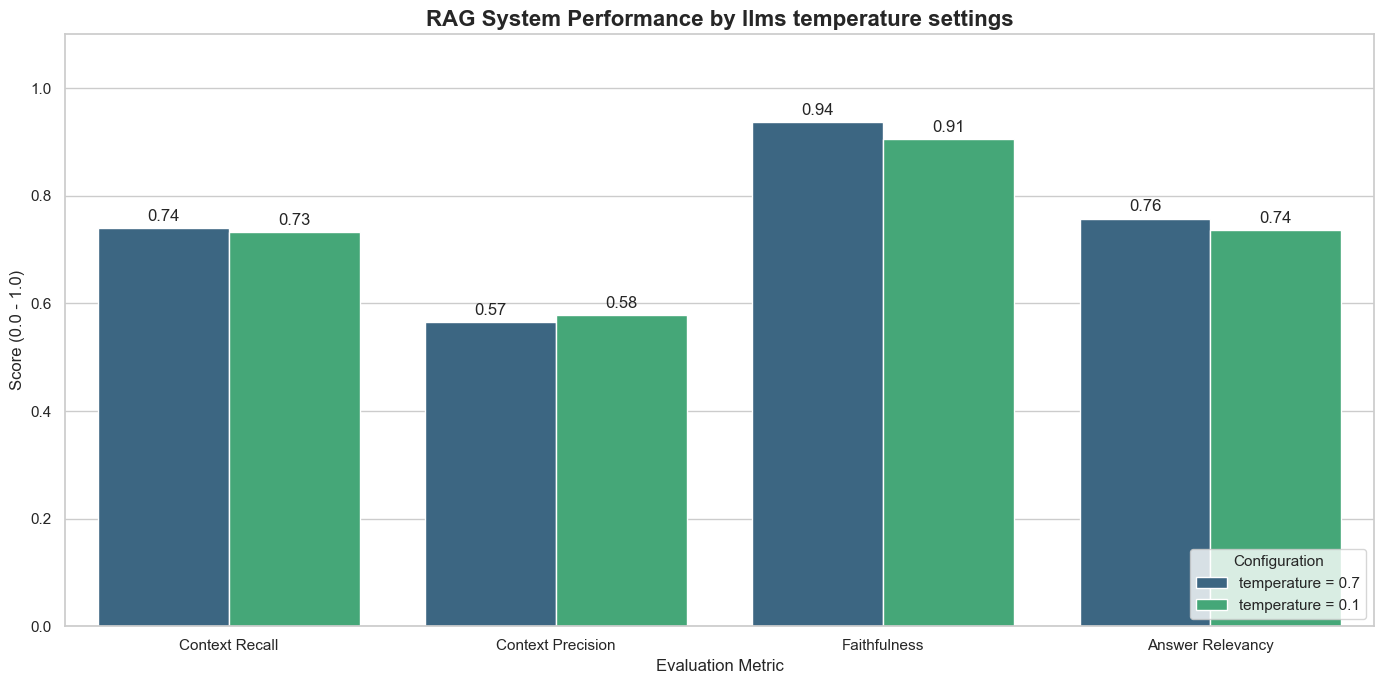

In [87]:
plot_results(final_df_temperature, "RAG System Performance by llms temperature settings")

# na końcu definujemy pliki na których chcemy testować , pliki takie tworzymy w skrypcie test_script.ipynb
### wazne zebydac dobre nazyw plikow i labelki bo to sie strasznie dlugo liczy!!
przykład z powyższych wywołań 
LLMS_FILES = {    
    "gpt4o-mini": "results_chunk_512_overlap_100_voyage3lite_gptmini_topk10_dist045.json",
    "llama-3.3-70B": "results_chunk_512_overlap_100_voyage3lite_llama3370B_topk10_dist045.json",
    "gemini-2.0-flash": "results_chunk_512_overlap_100_voyage3lite_gemini20_flash_topk10_dist045.json",
    "deepseek-v3.2": "results_chunk_512_overlap_100_voyage3lite_deepseek_v3_2_topk10_dist045.json"}

# potem  po kolei
all_results_LLMS = calculate_all_results(LLMS_FILES)  
final_df_LLMS = save_and_summarize_results(all_results_LLMS, filename="RAG_Analysis_LLMs_results.xlsx")  
plot_results(final_df_LLMS, "RAG System Performance by llms models")
